### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cloning the Git Repository at Google Drive

In [ ]:
!git clone https://github.com/leeyeehoo/CSRNet-pytorch.git "/content/drive/MyDrive/CSRNet-pytorch"

Cloning into '/content/drive/MyDrive/CSRNet-pytorch'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86
Unpacking objects: 100% (86/86), done.


### Changing working directory

In [ ]:
%cd /content/drive/MyDrive/CSRNet-pytorch

/content/drive/MyDrive/CSRNet-pytorch


### Importing required modules and files

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
from matplotlib import cm as c
%matplotlib inline

### Loading the image

In [ ]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import cv2

def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path)
    target = np.asarray(gt_file['density'])
    if False:
        crop_size = (img.size[0]/2,img.size[1]/2)
        if random.randint(0,9)<= -1:
            
            
            dx = int(random.randint(0,1)*img.size[0]*1./2)
            dy = int(random.randint(0,1)*img.size[1]*1./2)
        else:
            dx = int(random.random()*img.size[0]*1./2)
            dy = int(random.random()*img.size[1]*1./2)
        
        
        
        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
        target = target[dy:crop_size[1]+dy,dx:crop_size[0]+dx]
        
        
        
        
        if random.random()>0.8:
            target = np.fliplr(target)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    
    
    
    target = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    
    return img,target

### Function for creating Density map for images

In [ ]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

### Setting the path for dataset

In [ ]:
root = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech'

In [ ]:
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

### Generating Ground truth

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_176.jpg
(380, 594)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_205.jpg
(798, 1017)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_133.jpg
(683, 1024)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_142.jpg
(455, 670)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_227.jpg
(405, 609)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_118.jpg
(651, 1024)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_167.jpg
(830, 1024)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images/IMG_222.jpg
(522, 1024)
generate density...
done.
/content/drive/MyDrive/Datasets/ShanghaiTec

### Showing a sample image and its ground truth

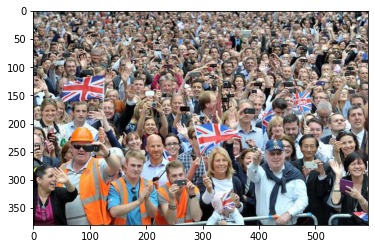

In [ ]:
plt.imshow(Image.open(img_paths[0]))

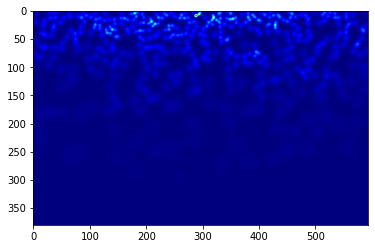

In [ ]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)

414.189

### Defining the CSRNet Architecture

In [ ]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

### Defining Location of Dataset

In [ ]:
#defining the location of dataset
root = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech'
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_test]

In [ ]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

### Training the model

In [ ]:
import sys
import os

import warnings

from model import CSRNet

from utils import save_checkpoint

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import argparse
import json
import cv2
import dataset
import time

parser = argparse.ArgumentParser(description='PyTorch CSRNet')

parser.add_argument('train_json', metavar='TRAIN',
                    help='path to train json')
parser.add_argument('test_json', metavar='TEST',
                    help='path to test json')

parser.add_argument('--pre', '-p', metavar='PRETRAINED', default=None,type=str,
                    help='path to the pretrained model')

parser.add_argument('gpu',metavar='GPU', type=str,
                    help='GPU id to use.')

parser.add_argument('task',metavar='TASK', type=str,
                    help='task id to use.')

def main():
    
    global args,best_prec1
    
    best_prec1 = 1e6
    
    args = parser.parse_args()
    args.original_lr = 1e-7
    args.lr = 1e-7
    args.batch_size    = 1
    args.momentum      = 0.95
    args.decay         = 5*1e-4
    args.start_epoch   = 0
    args.epochs = 15
    args.steps         = [-1,1,100,150]
    args.scales        = [1,1,1,1]
    args.workers = 4
    args.seed = time.time()
    args.print_freq = 30
    with open(args.train_json, 'r') as outfile:        
        train_list = json.load(outfile)
    with open(args.test_json, 'r') as outfile:       
        val_list = json.load(outfile)
    
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    torch.cuda.manual_seed(args.seed)
    
    model = CSRNet()
    
    model = model.cuda()
    
    criterion = nn.MSELoss(size_average=False).cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.decay)

    if args.pre:
        if os.path.isfile(args.pre):
            print("=> loading checkpoint '{}'".format(args.pre))
            checkpoint = torch.load(args.pre)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.pre, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.pre))
            
    for epoch in range(args.start_epoch, args.epochs):
        
        adjust_learning_rate(optimizer, epoch)
        
        train(train_list, model, criterion, optimizer, epoch)
        prec1 = validate(val_list, model, criterion)
        
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        print(' * best MAE {mae:.3f} '
              .format(mae=best_prec1))
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.pre,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best,args.task)

def train(train_list, model, criterion, optimizer, epoch):
    
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    
    
    train_loader = torch.utils.data.DataLoader(
        dataset.listDataset(train_list,
                       shuffle=True,
                       transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]), 
                       train=True, 
                       seen=model.seen,
                       batch_size=args.batch_size,
                       num_workers=args.workers),
        batch_size=args.batch_size)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), args.lr))
    
    model.train()
    end = time.time()
    
    for i,(img, target)in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        img = img.cuda()
        img = Variable(img)
        output = model(img)
        
        
        
        
        target = target.type(torch.FloatTensor).unsqueeze(0).cuda()
        target = Variable(target)
        
        
        loss = criterion(output, target)
        
        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))
    
def validate(val_list, model, criterion):
    print ('begin test')
    test_loader = torch.utils.data.DataLoader(
    dataset.listDataset(val_list,
                   shuffle=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]),  train=False),
    batch_size=args.batch_size)    
    
    model.eval()
    
    mae = 0
    
    for i,(img, target) in enumerate(test_loader):
        img = img.cuda()
        img = Variable(img)
        output = model(img)
        
        mae += abs(output.data.sum()-target.sum().type(torch.FloatTensor).cuda())
        
    mae = mae/len(test_loader)    
    print(' * MAE {mae:.3f} '
              .format(mae=mae))

    return mae    
        
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    
    args.lr = args.original_lr
    
    for i in range(len(args.steps)):
        
        scale = args.scales[i] if i < len(args.scales) else 1
        
        
        if epoch >= args.steps[i]:
            args.lr = args.lr * scale
            if epoch == args.steps[i]:
                break
        else:
            break
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr
        
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count    
    
if __name__ == '__main__':
    main()        

In [ ]:
model = CSRNet()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
#defining the model
model = model.cuda()

In [ ]:
!ls

0checkpoint.pth_5_epoch.tar  part_A_test.json		 part_B_val.json
0model_best.pth_5_epoch.tar  part_A_train.json		 __pycache__
dataset.py		     part_A_train_with_val.json  README.md
image.py		     part_A_val.json		 train.py
make_dataset.ipynb	     part_B_test.json		 utils.py
make_model.ipynb	     part_B_train.json		 val.ipynb
model.py		     part_B_train_with_val.json


In [ ]:
!python train.py part_A_train.json part_A_val.json 0 0

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 0, processed 0 samples, lr 0.0000001000
Epoch: [0][0/1200]	Time 1.809 (1.809)	Data 1.293 (1.293)	Loss 19.4384 (19.4384)	
Epoch: [0][30/1200]	Time 1.217 (1.246)	Data 0.732 (0.850)	Loss 226.2799 (331.3978)	
Epoch: [0][60/1200]	Time 0.836 (1.201)	Data 0.726 (0.794)	Loss 25.5552 (419.8890)	
Epoch: [0][90/1200]	Time 1.244 (1.171)	Data 0.816 (0.758)	Loss 125.6395 (431.7466)	
Epoch: [0][120/1200]	Time 1.012 (1.139)	Data 0.739 (0.736)	Loss 66.0249 (459.2357)	
Epoch: [0][150/1200]	Time 1.240 (1.142)	Data 0.039 (0.725)	Loss 90.4761 (435.6711)	
Epoch: [0][180/1200]	Time 1.242 (1.132)	Data 0.770 (0.692)	Loss 216.9907 (407.5578)	
Epoch: [0][210/1200]	Time 0.317 (1.119)	Data 0.018 (0.657)	Loss 49.4071 (419.5764)	
Epoch: [0][240/1200]	Time 0.694 (1.101)	Data 0.039 (0.631)	Loss 164.4525 (395.7316)	

### Loading the model

In [ ]:
#loading the trained weights
checkpoint = torch.load('0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Testing

In [ ]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground-truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [03:13<00:00,  1.06s/it]

85.16341427394322


Predicted Count :  373


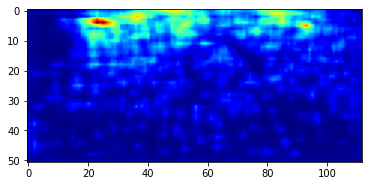

Original Count :  382


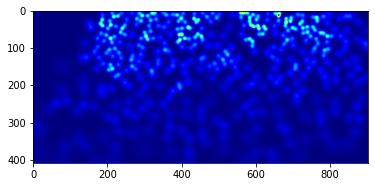

Original Image


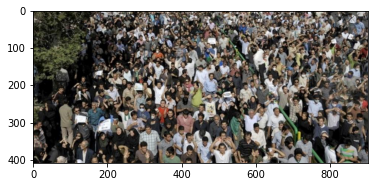

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_100.jpg'))
plt.show()

Predicted Count :  121


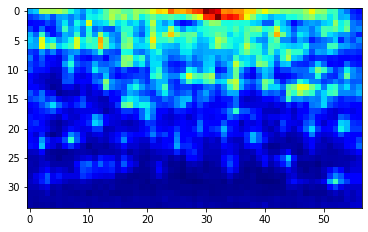

Original Count :  112


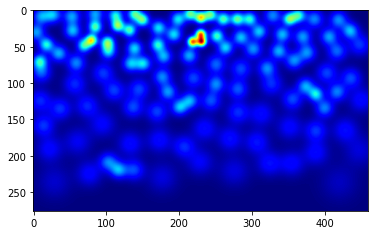

Original Image


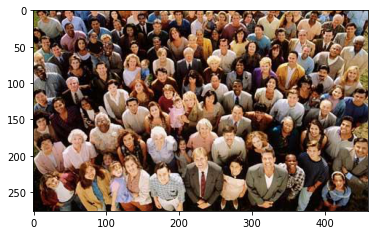

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_123.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_123.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_123.jpg'))
plt.show()

Predicted Count :  1848


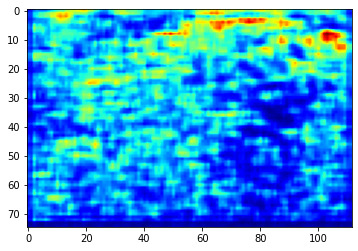

Original Count :  1589


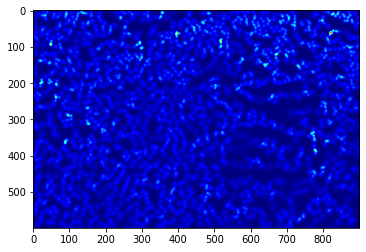

Original Image


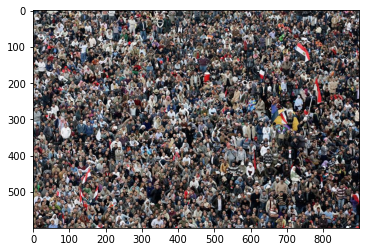

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_117.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_117.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_117.jpg'))
plt.show()

Predicted Count :  1253


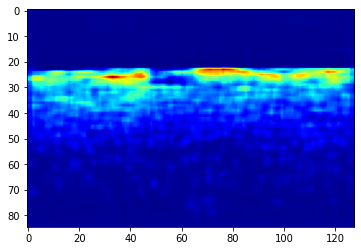

Original Count :  1205


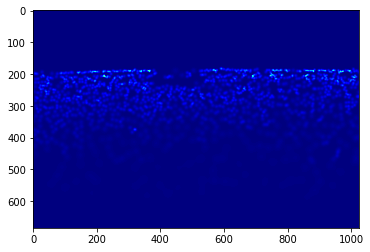

Original Image


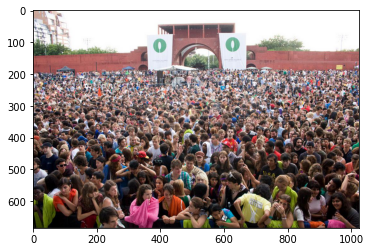

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_121.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_121.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_121.jpg'))
plt.show()

## testing with sparse data

In [ ]:
img_path = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_10.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
print(mat)
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]
gt
# for i in range(0,len(gt)):
#     if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
#         k[int(gt[i][1]),int(gt[i][0])]=1
# k = gaussian_filter_density(k)
# with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
#         hf['density'] = k

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:05:26 2016', '__version__': '1.0', '__globals__': [], 'image_info': array([[array([[(array([[130.4107441 , 644.966098  ],
                       [116.47245009, 631.02780399],
                       [301.85176044, 713.26373866],
                       ...,
                       [582.24377495, 249.46700544],
                       [583.28914701, 255.04232305],
                       [592.34903811, 247.72471869]]), array([[502]], dtype=uint16))]],
              dtype=[('location', 'O'), ('number', 'O')])                              ]],
      dtype=object)}


array([[130.4107441 , 644.966098  ],
       [116.47245009, 631.02780399],
       [301.85176044, 713.26373866],
       ...,
       [582.24377495, 249.46700544],
       [583.28914701, 255.04232305],
       [592.34903811, 247.72471869]])

In [ ]:
img_path = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1000.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
print(mat['M'])
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["M"][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
        hf['density'] = k

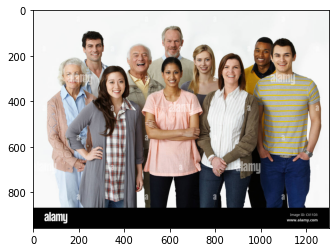

In [ ]:
plt.imshow(Image.open(img_path))

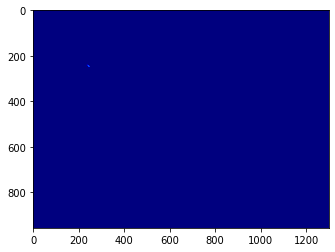

In [ ]:
gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)

12.0

Predicted Count :  92


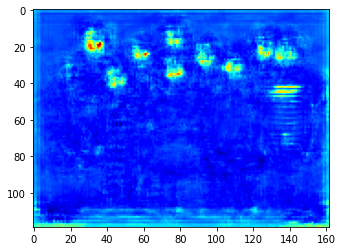

Original Count :  13


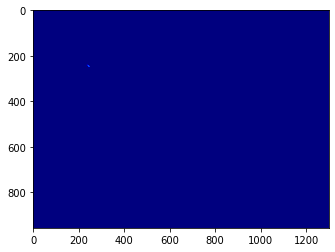

Original Image


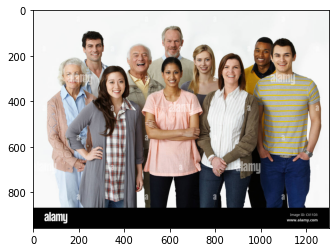

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1000.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_1000.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1000.jpg'))
plt.show()

In [ ]:
img_path = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1001.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
print(mat['M'])
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["M"][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
        hf['density'] = k

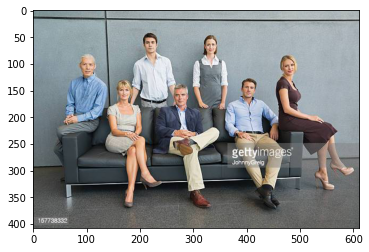

In [ ]:
plt.imshow(Image.open(img_path))

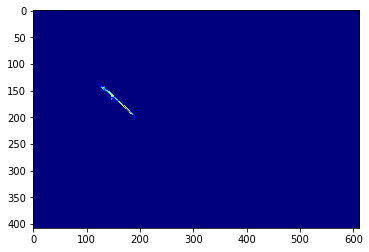

In [ ]:
gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)

158.85773

Predicted Count :  19


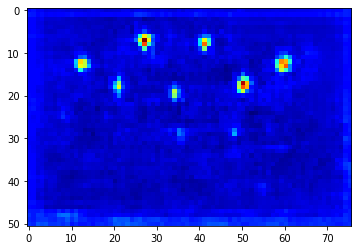

Original Count :  159


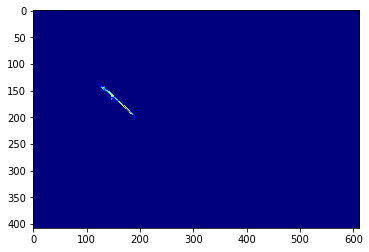

Original Image


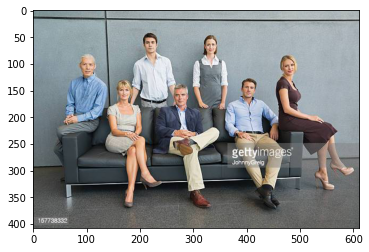

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1001.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_1001.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1001.jpg'))
plt.show()

In [ ]:
img_path = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1002.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
#print(mat['M'])
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["M"][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
        hf['density'] = k

(1152, 960)
generate density...
done.


470.99997


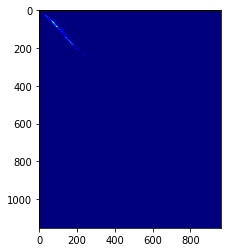

In [ ]:
gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])

print(np.sum(groundtruth))
plt.imshow(groundtruth,cmap=CM.jet)

Predicted Count :  74


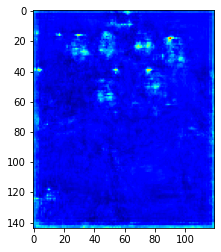

Original Count :  471


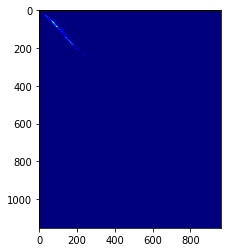

Original Image


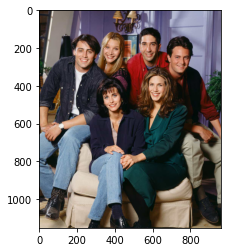

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1002.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_1002.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1002.jpg'))
plt.show()

## Testing with dense data

In [ ]:
img_path = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1003.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
#print(mat['M'])
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["M"][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
        hf['density'] = k

(1047, 1440)
generate density...
done.


1160.2346


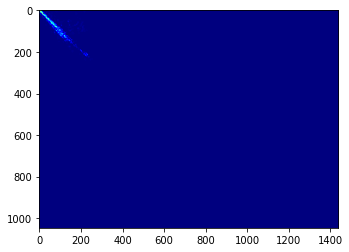

In [ ]:
gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])

print(np.sum(groundtruth))
plt.imshow(groundtruth,cmap=CM.jet)

Predicted Count :  3140


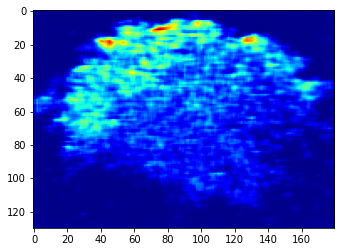

Original Count :  1161


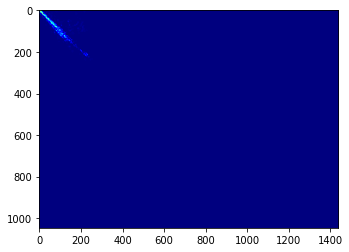

Original Image


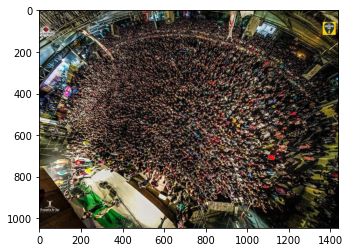

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1003.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_1003.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1003.jpg'))
plt.show()

In [ ]:
img_path = '/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1004.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
#print(mat['M'])
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["M"][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
        hf['density'] = k

(1614, 1440)
generate density...
done.


786.5471


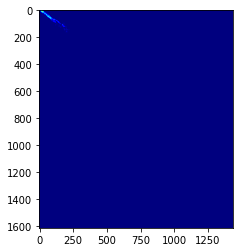

In [ ]:
gt_file = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])

print(np.sum(groundtruth))
plt.imshow(groundtruth,cmap=CM.jet)

Predicted Count :  1234


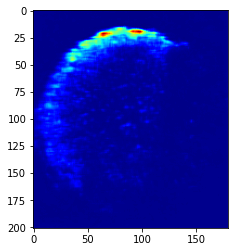

Original Count :  787


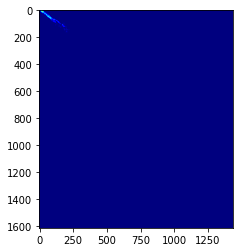

Original Image


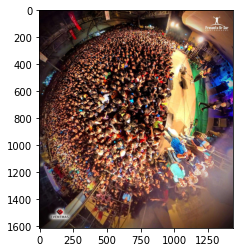

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1004.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/ground-truth/IMG_1004.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/CMI/Semester 4/Computer Vision/CV Project/ShanghaiTech/part_A/test_data/images/IMG_1004.jpg'))
plt.show()

### Others

In [ ]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
model = CSRNet()

In [ ]:
x = torch.rand((1,3,255,255))

In [ ]:
model(x).shape

torch.Size([1, 1, 31, 31])

In [ ]:
import sys
import os

import warnings


from utils import save_checkpoint

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import argparse
import json
import cv2
import dataset
import time

parser = argparse.ArgumentParser(description='PyTorch CSRNet')

parser.add_argument('train_json', metavar='TRAIN',
                    help='path to train json')
parser.add_argument('test_json', metavar='TEST',
                    help='path to test json')

parser.add_argument('--pre', '-p', metavar='PRETRAINED', default=None,type=str,
                    help='path to the pretrained model')

parser.add_argument('gpu',metavar='GPU', type=str,
                    help='GPU id to use.')

parser.add_argument('task',metavar='TASK', type=str,
                    help='task id to use.')

def main():
    
    global args,best_prec1
    
    best_prec1 = 1e6
    
    args = parser.parse_args()
    args.original_lr = 1e-7
    args.lr = 1e-7
    args.batch_size    = 1
    args.momentum      = 0.95
    args.decay         = 5*1e-4
    args.start_epoch   = 0
    args.epochs = 400
    args.steps         = [-1,1,100,150]
    args.scales        = [1,1,1,1]
    args.workers = 4
    args.seed = time.time()
    args.print_freq = 30
    with open(args.train_json, 'r') as outfile:        
        train_list = json.load(outfile)
    with open(args.test_json, 'r') as outfile:       
        val_list = json.load(outfile)
    
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    torch.cuda.manual_seed(args.seed)
    
    model = CSRNet()
    
    model = model.cuda()
    
    criterion = nn.MSELoss(size_average=False).cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.decay)

    if args.pre:
        if os.path.isfile(args.pre):
            print("=> loading checkpoint '{}'".format(args.pre))
            checkpoint = torch.load(args.pre)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.pre, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.pre))
            
    for epoch in range(args.start_epoch, args.epochs):
        
        adjust_learning_rate(optimizer, epoch)
        
        train(train_list, model, criterion, optimizer, epoch)
        prec1 = validate(val_list, model, criterion)
        
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        print(' * best MAE {mae:.3f} '
              .format(mae=best_prec1))
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.pre,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best,args.task)

def train(train_list, model, criterion, optimizer, epoch):
    
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    
    
    train_loader = torch.utils.data.DataLoader(
        dataset.listDataset(train_list,
                       shuffle=True,
                       transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]), 
                       train=True, 
                       seen=model.seen,
                       batch_size=args.batch_size,
                       num_workers=args.workers),
        batch_size=args.batch_size)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), args.lr))
    
    model.train()
    end = time.time()
    
    for i,(img, target)in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        img = img.cuda()
        img = Variable(img)
        output = model(img)
        
        
        
        
        target = target.type(torch.FloatTensor).unsqueeze(0).cuda()
        target = Variable(target)
        
        
        loss = criterion(output, target)
        
        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))
    
def validate(val_list, model, criterion):
    print ('begin test')
    test_loader = torch.utils.data.DataLoader(
    dataset.listDataset(val_list,
                   shuffle=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]),  train=False),
    batch_size=args.batch_size)    
    
    model.eval()
    
    mae = 0
    
    for i,(img, target) in enumerate(test_loader):
        img = img.cuda()
        img = Variable(img)
        output = model(img)
        
        mae += abs(output.data.sum()-target.sum().type(torch.FloatTensor).cuda())
        
    mae = mae/len(test_loader)    
    print(' * MAE {mae:.3f} '
              .format(mae=mae))

    return mae    
        
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    
    args.lr = args.original_lr
    
    for i in range(len(args.steps)):
        
        scale = args.scales[i] if i < len(args.scales) else 1
        
        
        if epoch >= args.steps[i]:
            args.lr = args.lr * scale
            if epoch == args.steps[i]:
                break
        else:
            break
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr
        
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count   